In [1]:
import pandas as pd
import numpy as np

import os
import sys

import librosa
import librosa.display
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.model_selection import train_test_split

from IPython.display import Audio

import tensorflow as tf
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [2]:
Crema = "AudioWAV/"

In [3]:
crema_directory_list = os.listdir(Crema)

file_emotion = []
file_path = []

for file in crema_directory_list:
    # storing file paths
    file_path.append(Crema + file)
    # storing file emotions
    part=file.split('_')
    if part[2] == 'SAD':
        file_emotion.append('sad')
    elif part[2] == 'ANG':
        file_emotion.append('angry')
    elif part[2] == 'DIS':
        file_emotion.append('disgust')
    elif part[2] == 'FEA':
        file_emotion.append('fear')
    elif part[2] == 'HAP':
        file_emotion.append('happy')
    elif part[2] == 'NEU':
        file_emotion.append('neutral')
    else:
        file_emotion.append('Unknown')
        
# dataframe for emotion of files
emotion_df = pd.DataFrame(file_emotion, columns=['Emotions'])

# dataframe for path of files.
path_df = pd.DataFrame(file_path, columns=['Path'])
Crema_df = pd.concat([emotion_df, path_df], axis=1)
Crema_df.head()

,Emotions,Path
0,angry,AudioWAV/1001_DFA_ANG_XX.wav
1,disgust,AudioWAV/1001_DFA_DIS_XX.wav
2,fear,AudioWAV/1001_DFA_FEA_XX.wav
3,happy,AudioWAV/1001_DFA_HAP_XX.wav
4,neutral,AudioWAV/1001_DFA_NEU_XX.wav


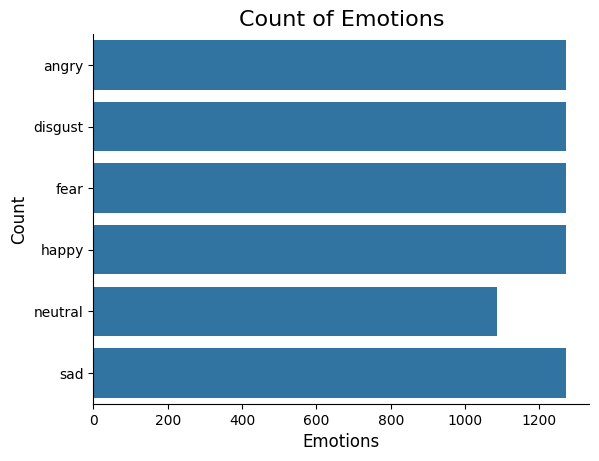

In [4]:
plt.title('Count of Emotions', size=16)
sns.countplot(Crema_df.Emotions)
plt.ylabel('Count', size=12)
plt.xlabel('Emotions', size=12)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.show()

In [5]:
def create_waveplot(data, sr, e):
    plt.figure(figsize=(10, 3))
    plt.title('Waveplot for {} emotion'.format(e), size=15)
    librosa.display.waveshow(data, sr=sr)
    plt.show()

def create_spectrogram(data, sr, e):
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    plt.figure(figsize=(12, 3))
    plt.title('Spectrogram for {} emotion'.format(e), size=15)
    librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')   
    plt.colorbar()

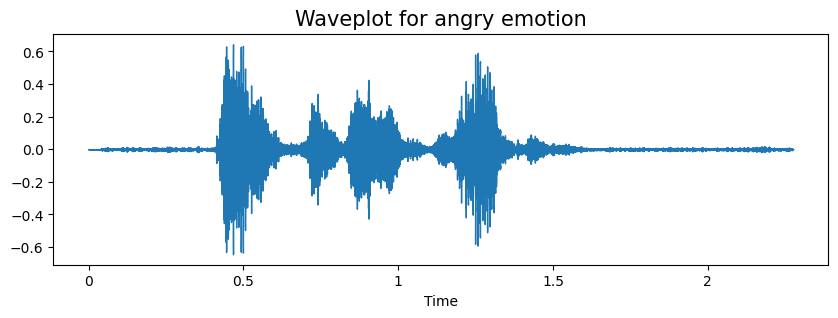

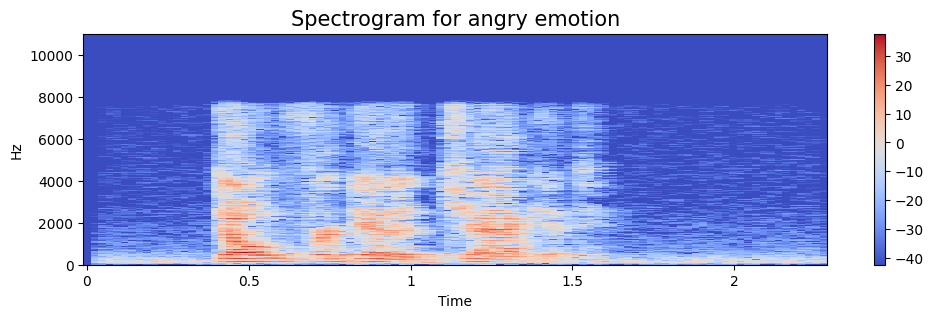

In [6]:
emotion='angry'
path = np.array(Crema_df.Path[Crema_df.Emotions==emotion])[0]
data, sampling_rate = librosa.load(path)
create_waveplot(data, sampling_rate, emotion)
create_spectrogram(data, sampling_rate, emotion)
Audio(path)

In [7]:
labels = {'disgust':0,'happy':1,'sad':2,'neutral':3,'fear':4,'angry':5}
Crema_df.replace({'Emotions':labels},inplace=True)

In [8]:
num_mfcc=13
n_fft=2048
hop_length=512
SAMPLE_RATE = 22050
data = {
        "labels": [],
        "mfcc": []
    }
for i in range(7442):
    data['labels'].append(Crema_df.iloc[i,0])
    signal, sample_rate = librosa.load(Crema_df.iloc[i,1], sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)

    mfcc = mfcc.T
    data["mfcc"].append(np.asarray(mfcc))
    if i%500==0:
        print(i)

0
500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000


In [9]:
import numpy as np

def pad_or_truncate(mfcc, max_len=130):
    if mfcc.shape[0] < max_len:
        pad_width = max_len - mfcc.shape[0]
        return np.pad(mfcc, pad_width=((0, pad_width), (0, 0)), mode='constant')
    else:
        return mfcc[:max_len, :]


In [10]:
data = {"mfcc": [], "labels": []}
SAMPLE_RATE = 22050

for i in range(len(Crema_df)):
    emotion = Crema_df.iloc[i, 0]
    path = Crema_df.iloc[i, 1]
    
    signal, sample_rate = librosa.load(path, sr=SAMPLE_RATE)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=13, n_fft=2048, hop_length=512)
    mfcc = mfcc.T  # Shape = (time, n_mfcc)

    mfcc = pad_or_truncate(mfcc, max_len=130)  # Now shape is fixed (130, 13)
    
    data["mfcc"].append(mfcc)
    data["labels"].append(emotion)


In [11]:
X = np.asarray(data['mfcc'])
y = np.asarray(data["labels"])

In [12]:
X = tf.keras.preprocessing.sequence.pad_sequences(X)
X.shape

(7442, 130, 13)

In [13]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1)
X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=0.2)

In [14]:
print(X_train.shape,y_train.shape,X_validation.shape,y_validation.shape,X_test.shape,y_test.shape)

(5357, 130, 13) (5357,) (1340, 130, 13) (1340,) (745, 130, 13) (745,)


In [15]:
def build_model(input_shape):
    model = tf.keras.Sequential()

    model.add(LSTM(128, input_shape=input_shape, return_sequences=True))
    model.add(LSTM(64))
    
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(0.3))

    model.add(Dense(6, activation='softmax'))

    return model

In [16]:
# create network
input_shape = (None,13)
model = build_model(input_shape)

# compile model
optimiser = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(optimizer=optimiser,
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                          │ (None, None, 128)           │          72,704 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           4,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 6)                   │             390 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 126,662 (494.77 KB)

 Trainable params: 126,662 (494.77 KB)

 Non-trainable params: 0 (0.00 B)

In [17]:
history = model.fit(X_train, y_train, validation_data=(X_validation, y_validation), batch_size=32, epochs=30)

Epoch 1/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 76s 362ms/step - accuracy: 0.2924 - loss: 1.6720 - val_accuracy: 0.4201 - val_loss: 1.4461
Epoch 2/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 62s 371ms/step - accuracy: 0.3824 - loss: 1.4992 - val_accuracy: 0.4343 - val_loss: 1.3997
Epoch 3/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 59s 352ms/step - accuracy: 0.4157 - loss: 1.4423 - val_accuracy: 0.4448 - val_loss: 1.3675
Epoch 4/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 60s 356ms/step - accuracy: 0.4210 - loss: 1.4047 - val_accuracy: 0.4351 - val_loss: 1.3798
Epoch 5/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 58s 343ms/step - accuracy: 0.4595 - loss: 1.3856 - val_accuracy: 0.4522 - val_loss: 1.3738
Epoch 7/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 57s 341ms/step - accuracy: 0.4555 - loss: 1.3772 - val_accuracy: 0.4425 - val_loss: 1.3819
Epoch 8/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 63s 373ms/step - accuracy: 0.4328 - loss: 1.3860 - val_accuracy: 0.4530 - val_loss: 1.3576
Epoch 9/30
168/168 ━━━━━━━━━━━━━━━━━━━━ 108s 643ms/step - accuracy: 0.4509 - loss: 

In [18]:
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=0)
print("Test Accuracy: ",test_acc)

Test Accuracy:  0.4939597249031067


In [20]:
model.export("Speech-Emotion-Recognition-Model")

INFO:tensorflow:Assets written to: Speech-Emotion-Recognition-Model\assets


INFO:tensorflow:Assets written to: Speech-Emotion-Recognition-Model\assets


Saved artifact at 'Speech-Emotion-Recognition-Model'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, None, 13), dtype=tf.float32, name='keras_tensor')
Output Type:
  TensorSpec(shape=(None, 6), dtype=tf.float32, name=None)
Captures:
  2059692105168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2059759094944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2059759310576: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2059759689696: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2059759692160: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2059759694272: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2059759696032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2059759696736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2059784365760: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2059784363824: TensorSpec(shape=(), dtype=tf.resource, name=None)
